In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np
import torch

In [2]:
hidden_size = 64
hidden_layers_dim = 8

# Simple NN
class MultiLayerPerceptron(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.input_layer = torch.nn.Linear(input_dim, hidden_size)

        hidden_layers = []
        for i in range(hidden_layers_dim):
            hidden_layers.append(torch.nn.Linear(hidden_size, hidden_size))

        self.hidden_layer = torch.nn.ModuleList(hidden_layers)
        self.out_layer = torch.nn.Linear(hidden_size, 1)

    def forward(self, x):

        x = self.input_layer(x)
        for layer in self.hidden_layer:
            x = torch.tanh(layer(x))
        x = self.out_layer(x)
        return x


Successfully loaded model: best_model_epoch_9.pth
Successfully loaded model: best_model_epoch_9.pth
Successfully loaded model: best_model_epoch_10.pth
Successfully loaded model: best_model_epoch_10.pth


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Figure successfully saved as nn_surrogate_orientation_heatmaps.eps


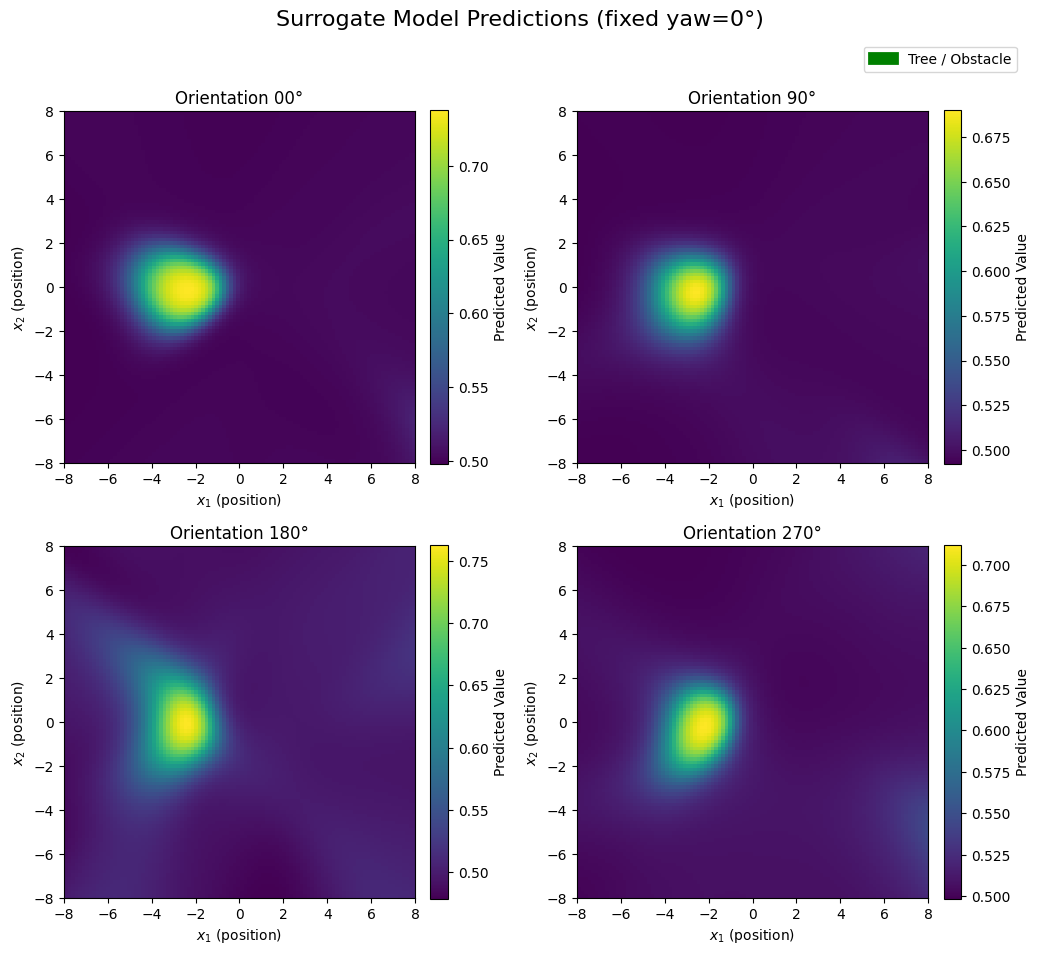

Script finished.


In [5]:
SCRIPT_DIR = os.path.abspath('')

RELATIVE_MODEL_PATHS = [
    "datasets/varying_orientation_datasets/00-degrees/20250423_114142/best_model_epoch_9.pth",
    "datasets/varying_orientation_datasets/90-degrees/20250423_114841/best_model_epoch_9.pth",
    "datasets/varying_orientation_datasets/180-degrees/20250423_115209/best_model_epoch_10.pth",
    "datasets/varying_orientation_datasets/270-degrees/20250423_120415/best_model_epoch_10.pth"
]

MODEL_PATHS = [os.path.join(SCRIPT_DIR, rel_path) for rel_path in RELATIVE_MODEL_PATHS]

TITLES = ["Orientation 00°", "Orientation 90°", "Orientation 180°", "Orientation 270°"]

X_MIN, X_MAX = -8, 8  
Y_MIN, Y_MAX = -8, 8  
N_POINTS = 100        
FIXED_YAW_RAD = 0.0   

MODEL_INPUT_DIM = 4
MODEL_HIDDEN_DIM = 64
MODEL_OUTPUT_DIM = 1
MODEL_NUM_LAYERS = 8 
MODEL_ACTIVATION = 'Tanh'


FIGURE_SIZE = (10.5, 10)
TREE_RADIUS = 0.5        
OUTPUT_FILENAME = 'nn_surrogate_orientation_heatmaps.eps'

x_coordinates = np.linspace(X_MIN, X_MAX, N_POINTS)
y_coordinates = np.linspace(Y_MIN, Y_MAX, N_POINTS)

X_grid_mesh, Y_grid_mesh = np.meshgrid(x_coordinates, y_coordinates)
num_grid_points = X_grid_mesh.size

sin_fixed_yaw = np.sin(FIXED_YAW_RAD)
cos_fixed_yaw = np.cos(FIXED_YAW_RAD)

X_input_for_model = np.column_stack([
    X_grid_mesh.ravel(),
    Y_grid_mesh.ravel(),
    np.full(num_grid_points, sin_fixed_yaw),
    np.full(num_grid_points, cos_fixed_yaw) 
])

fig, axes = plt.subplots(2, 2, figsize=FIGURE_SIZE)
fig.suptitle(f"Surrogate Model Predictions (fixed yaw={np.degrees(FIXED_YAW_RAD):.0f}°)", fontsize=16)

legend_handles_for_figure = []

for idx, (model_path, title) in enumerate(zip(MODEL_PATHS, TITLES)):
    ax_row = idx // 2
    ax_col = idx % 2
    current_ax = axes[ax_row, ax_col]

    try:

        model = l4c.naive.MultiLayerPerceptron(
            MODEL_INPUT_DIM,
            MODEL_HIDDEN_DIM,
            MODEL_OUTPUT_DIM,
            MODEL_NUM_LAYERS,
            MODEL_ACTIVATION
        )
        state_dict = torch.load(model_path, map_location=torch.device('cpu'))
        model.load_state_dict(state_dict)
        model.eval()
        print(f"Successfully loaded model: {os.path.basename(model_path)}")

    except FileNotFoundError:
        print(f"ERROR: Model file not found at {model_path}. Skipping this plot.")
        current_ax.set_title(f"{title}\n(Model Not Found)")
        current_ax.text(0.5, 0.5, 'Model file missing',
                        horizontalalignment='center', verticalalignment='center',
                        transform=current_ax.transAxes, color='red')
        current_ax.set_xticks([])
        current_ax.set_yticks([])
        continue

    except Exception as e:
        print(f"ERROR: Could not load model {model_path}: {e}. Skipping this plot.")
        current_ax.set_title(f"{title}\n(Model Load Error)")
        current_ax.text(0.5, 0.5, 'Error loading model',
                        horizontalalignment='center', verticalalignment='center',
                        transform=current_ax.transAxes, color='red')
        current_ax.set_xticks([])
        current_ax.set_yticks([])
        continue 

    with torch.no_grad():
        inputs_tensor = torch.tensor(X_input_for_model, dtype=torch.float32)
        predictions_tensor = model(inputs_tensor)
        z_predictions_flat = predictions_tensor.numpy().ravel()

    Z_heatmap_data = z_predictions_flat.reshape(N_POINTS, N_POINTS) + 0.5

    heatmap_image = current_ax.imshow(
        Z_heatmap_data,
        origin='lower', 
        extent=[X_MIN, X_MAX, Y_MIN, Y_MAX],
        aspect='equal',  
        cmap='viridis'   
    )
    current_ax.set_title(title)
    current_ax.set_xlabel(r'$x_1$ (position)')
    current_ax.set_ylabel(r'$x_2$ (position)')

    if not legend_handles_for_figure:
        tree_circle_patch = Circle(
            (0, 0),                 
            radius=TREE_RADIUS,
            edgecolor='green',
            facecolor='green',
            linewidth=2,
            label='Tree / Obstacle'  
        )
        legend_handles_for_figure.append(tree_circle_patch)

    cbar = fig.colorbar(heatmap_image, ax=current_ax, label='Predicted Value', fraction=0.046, pad=0.04)

if legend_handles_for_figure:
    fig.legend(handles=legend_handles_for_figure, loc='upper right', bbox_to_anchor=(0.98, 0.95))


plt.tight_layout(rect=[0, 0.03, 1, 0.95]) #[left, bottom, right, top]

try:
    fig.savefig(OUTPUT_FILENAME, format='eps', bbox_inches='tight')
    print(f"Figure successfully saved as {OUTPUT_FILENAME}")
except Exception as e:
    print(f"ERROR: Could not save figure: {e}")

plt.show()

print("Script finished.")